In [19]:
import pandas as pd
import numpy as np
# # set up dictionaries of parameter options for each learner
param_opts = {
    'DecisionTreeClassifier': {},
    'GradientBoostingClassifier': {},
    'KNeighborsClassifier': {},
    'LogisticRegression': {},
    'RandomForestClassifier': {},
    'SVC': {}
}
ml_p = pd.read_csv('ml_p_options.csv')
ml_p.rename(columns={'alg_name':'classifier'},inplace=True)
for ml, df_ml in ml_p.groupby('classifier'):
    for p, df_ml_p in df_ml.groupby('parameters'):
        d = eval(p)
        for keys,v in d.items():
            if keys not in param_opts[ml].keys():
                param_opts[ml][keys] = [v]
            elif v not in param_opts[ml][keys]:
                param_opts[ml][keys].append(v)
print(param_opts)

{'DecisionTreeClassifier': {'criterion': ['entropy', 'gini'], 'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5]}, 'GradientBoostingClassifier': {'learning_rate': [0.01, 0.1, 1], 'max_depth': [1, 10, 5], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5], 'n_estimators': [100, 250], 'subsample': [0.5, 1]}, 'KNeighborsClassifier': {'n_neighbors': [1, 11, 3, 5, 7, 9], 'p': [1, 2], 'weights': ['distance', 'uniform']}, 'LogisticRegression': {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 25], 'dual': ['false', 'true'], 'penalty': ['l1', 'l2']}, 'RandomForestClassifier': {'bootstrap': ['false', 'true'], 'criterion': ['entropy', 'gini'], 'max_features': ['log2', 'sqrt'], 'min_samples_leaf': [10, 20, 5], 'min_samples_split': [10, 20, 5], 'n_estimators': [100, 250]}, 'SVC': {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10, 25], 'kernel': ['poly', 'rbf'], 'tol': [0.0001, 0.001, 0.01, 0.1, 1e-05]}}


In [20]:
import pandas as pd
import numpy as np

data = pd.read_csv('sklearn-benchmark5-data-edited.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')
print(data.head())
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
print('loaded ',data['dataset'].unique().shape[0],'datasets and ', data['classifier'].unique().shape[0],'classifiers')
# subset data to classifiers used in PennAI
pennai_classifiers = ['LogisticRegression', 'RandomForestClassifier', 'SVC', 
                      'KNeighborsClassifier', 'DecisionTreeClassifier', 'GradientBoostingClassifier']
mask = np.array([c in pennai_classifiers for c in data['classifier'].values])
data = data.loc[mask,:]
print('datasets (',len(data['dataset'].unique()),')')
print('classifiers (',len(data['classifier'].unique()),'):',data['classifier'].unique())
for ml, df_g in data.groupby('classifier'):
    print('parameters for ',ml,'(',len(df_g['parameters'].unique()),'):',df_g['parameters'].unique()[:5])


/home/bill/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                                             dataset          classifier  \
0  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  AdaBoostClassifier   
1  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  AdaBoostClassifier   
2  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  AdaBoostClassifier   
3  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  AdaBoostClassifier   
4  GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...  AdaBoostClassifier   

                             parameters  accuracy   macrof1 bal_accuracy  
0    learning_rate=0.01,n_estimators=10  0.479375  0.470857   0.479375.1  
1   learning_rate=0.01,n_estimators=100  0.476875  0.476497     0.476875  
2  learning_rate=0.01,n_estimators=1000  0.488125  0.488115     0.488125  
3    learning_rate=0.01,n_estimators=50  0.483750  0.483652      0.48375  
4   learning_rate=0.01,n_estimators=500  0.495625  0.495609     0.495625  
loaded  166 datasets and  13 classifiers
datasets ( 166 )
classifiers ( 6 ): ['DecisionTreeCl

/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

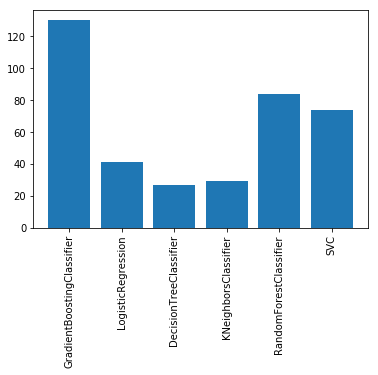

In [21]:
winner = {}
winner_datasets = {}
import numpy as np
for d, df in data.groupby('dataset'):
    df['bal_accuracy'] = df['bal_accuracy'].apply(pd.to_numeric)
    best_score = df['bal_accuracy'].max()
    for clf, dfg in df.groupby('classifier'):
        wins = np.any((best_score - dfg.bal_accuracy)/best_score <= 0.01)
        if wins:
            if clf in winner:
                winner[clf] += 1
                winner_datasets[clf].append(d)
            else:
                winner[clf] = 1
                winner_datasets[clf] = [d]
import matplotlib.pyplot as plt
%matplotlib inline
# print(winner)
# print(winner_datasets)
plt.bar(list(winner.keys()),list(winner.values()))
plt.xticks(rotation=90)               

# reduce GBC

In [22]:
n_est = ['n_estimators='+str(n) for n in [100,500,1000]]
max_depth = ['max_depth='+str(d) for d in [4,6,10]]
max_features = ['max_features='+str(f) for f in ['sqrt','log2']]

gbc = data['classifier']=='GradientBoostingClassifier'
mask = [False for g in gbc]
for n in n_est:
    mask = mask | (gbc & np.array([n in p for p in data['parameters'].values]))
mask = (mask | ~gbc)
data = data.loc[mask,:]

gbc = data['classifier']=='GradientBoostingClassifier'
mask = [False for g in gbc]
for n in max_depth:
    mask = mask | (gbc & np.array([n in p for p in data['parameters'].values]))
mask = (mask | ~gbc)
data = data.loc[mask,:]

gbc = data['classifier']=='GradientBoostingClassifier'
mask = [False for g in gbc]
for n in max_features:
    mask = mask | (gbc & np.array([n in p for p in data['parameters'].values]))
mask = (mask | ~gbc)
data = data.loc[mask,:]

# reduce RF

In [23]:
# reduce Random Forest n_estimators

rfc = data['classifier']=='RandomForestClassifier'
mask = [False for g in rfc]
for n in n_est:
    mask = mask | (rfc & np.array([n in p for p in data['parameters'].values]))
mask = (mask | ~rfc)
data = data.loc[mask,:]

max_features = ['max_features='+str(f) for f in ['sqrt','log2',None]]
rfc = data['classifier']=='RandomForestClassifier'
mask = [False for g in rfc]
for n in max_features:
    mask = mask | (rfc & np.array([n in p for p in data['parameters'].values]))
mask = (mask | ~rfc)
data = data.loc[mask,:]

data.groupby('classifier').count()

,dataset,parameters,accuracy,macrof1,bal_accuracy
classifier,,,,,
DecisionTreeClassifier,25410,25410,25410,25410,25410
GradientBoostingClassifier,20473,20473,20473,20473,20473
KNeighborsClassifier,8831,8831,8831,8831,8831
LogisticRegression,39145,39145,39145,39145,39145
RandomForestClassifier,32475,32475,32475,32475,32475
SVC,143179,143179,143179,143179,143179


In [24]:
from collections import OrderedDict

def convert_params(params):
    """convert from sklearn-style parameter formatting to dictionary, PennAI style."""
    pdict = {}
    for kv in params.split(','):
        if len(kv)==0: continue
#         print(kv.split('='))
        pdict[str(kv.split('=')[0])] = kv.split('=')[1]
    for k,v in pdict.items():
        try:
            pdict[k] = int(v)
        except ValueError:
            try:     
                pdict[k] = float(v)
            except ValueError:
                pass

    return OrderedDict(sorted(pdict.items()))


data['parameters'] = data['parameters'].apply(lambda x: convert_params(x))

In [25]:
for ml, df_g in data.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 154 ): OrderedDict([('criterion', 'entropy'), ('max_features', 0.1), ('min_weight_fraction_leaf', 0.0)])
example parameters for  GradientBoostingClassifier ( 168 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_depth', 10), ('max_features', 'log2'), ('n_estimators', 100)])
example parameters for  KNeighborsClassifier ( 54 ): OrderedDict([('n_neighbors', 1), ('weights', 'distance')])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'False'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 198 ): OrderedDict([('criterion', 'entropy'), ('max_features', 'None'), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 100)])
example parameters for  SVC ( 1239 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


In [ ]:
#def valid_param_combo(ml,params):
#     print('ml',ml,type(ml).__name__)
#     print('params',params,type(params).__name__)

#    for k,v in params.items():
#        if k in param_opts[ml].keys():
#            if param_opts[ml][k] is int:
#                try:
#                    if int(v) in param_opts[ml][k]:
#                        return True
#                except: 
#                    return False
#            elif param_opts[ml][k] is float:
#                try:
#                    if float(v) in param_opts[ml][k]:
#                        return True
#                except: 
#                    return False
#            elif v not in param_opts[ml][k]:
##                 if ml == 'LogisticRegression' and k=='C':
##                     print('eliminating',params,'for',ml,'with',k,':',v)
#                    return False
#    return True
#
#mask = [valid_param_combo(row['classifier'],row['parameters']) for _, row in data.iterrows()]
#mask = mask | data.classifier=='LogisticRegression'
#data_filtered = data.loc[mask]
#
## data_filtered = data.loc[lambda x: valid_param_combo(i['classifier'],i['parameters']) for i in x]


In [26]:
for ml, df_g in data.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 154 ): OrderedDict([('criterion', 'entropy'), ('max_features', 0.1), ('min_weight_fraction_leaf', 0.0)])
example parameters for  GradientBoostingClassifier ( 168 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_depth', 10), ('max_features', 'log2'), ('n_estimators', 100)])
example parameters for  KNeighborsClassifier ( 54 ): OrderedDict([('n_neighbors', 1), ('weights', 'distance')])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'False'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 198 ): OrderedDict([('criterion', 'entropy'), ('max_features', 'None'), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 100)])
example parameters for  SVC ( 1239 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


# how many winners of each algorithm are there? (winning = < 1% away from best score)

/home/bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


([0, 1, 2, 3, 4, 5], <a list of 6 Text xticklabel objects>)

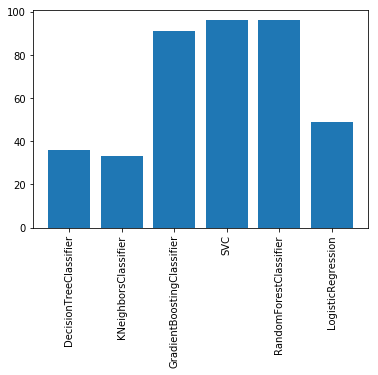

In [27]:
winner = {}
winner_datasets = {}
import numpy as np
for d, df in data.groupby('dataset'):
    df['bal_accuracy'] = df['bal_accuracy'].apply(pd.to_numeric)
    best_score = df['bal_accuracy'].max()
    for clf, dfg in df.groupby('classifier'):
        wins = np.any((best_score - dfg.bal_accuracy)/best_score <= 0.01)
        if wins:
            if clf in winner:
                winner[clf] += 1
                winner_datasets[clf].append(d)
            else:
                winner[clf] = 1
                winner_datasets[clf] = [d]
import matplotlib.pyplot as plt
%matplotlib inline
# print(winner)
# print(winner_datasets)
plt.bar(list(winner.keys()),list(winner.values()))
plt.xticks(rotation=90)               

In [28]:
import itertools
other_winners = [d for d in [da for k,da in winner_datasets.items() if k != 'GradientBoostingClassifier' ]]
other_winners = list(itertools.chain.from_iterable(other_winners))
print(other_winners) 
only_gbc = [d for d in winner_datasets['GradientBoostingClassifier'] 
            if d not in other_winners]
print(only_gbc)
len(only_gbc)

['GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1', 'agaricus-lepiota', 'allbp', 'analcatdata_bankruptcy', 'analcatdata_creditscore', 'analcatdata_cyyoung8092', 'analcatdata_fraud', 'ann-thyroid', 'appendicitis', 'chess', 'clean1', 'clean2', 'cleveland-nominal', 'cloud', 'colic', 'collins', 'corral', 'dis', 'heart-h', 'house-votes-84', 'irish', 'kddcup', 'kr-vs-kp', 'krkopt', 'led7', 'mofn-3-7-10', 'monk2', 'mushroom', 'mux6', 'nursery', 'segmentation', 'shuttle', 'soybean', 'threeOf9', 'wine-quality-red', 'xd6', 'GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1', 'agaricus-lepiota', 'analcatdata_authorship', 'analcatdata_dmft', 'banana', 'breast', 'breast-w', 'calendarDOW', 'cleve', 'confidence', 'dermatology', 'ecoli', 'heart-statlog', 'led24', 'led7', 'mfeat-factors', 'mfeat-pixel', 'mushroom', 'mux6', 'optdigits', 'parity5', 'pendigits', 'satimage', 'spect', 'tae', 'texture', 'threeOf9', 'tokyo1', 'twonorm', 'vowel', 'wine-quality-white', 'xd6', 'yeast', 'GAMETES_Epistasis_2

8

# remove datasets where GBC is the only winner

In [29]:
data = data[~data.dataset.isin(only_gbc)]
print('# datasets left:',len(data.dataset.unique()))

# datasets left: 157


In [30]:
print(data[data['classifier']=='KNeighborsClassifier']['parameters'].apply(str).unique())

["OrderedDict([('n_neighbors', 1), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 1), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 10), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 10), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 100), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 100), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 11), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 11), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 12), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 12), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 13), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 13), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 14), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 14), ('weights', 'uniform')])"
 "OrderedDict([('n_neighbors', 15), ('weights', 'distance')])"
 "OrderedDict([('n_neighbors', 15), ('weights', 'uniform')])"


# remove big datasets

In [31]:
data_filtered = data
#datasets to remove:
big_datasets = ['poker', 'kddcup', 'sleep', 'fars', 'mnist', 'connect-4', 'shuttle', 'adult', 'krkopt', 
                'letter', 'magic', 'nursery', 'pendigits', 'coil2000', 'agaricus-lepiota','optdigits']
mask = np.array([d not in big_datasets for d in data_filtered['dataset'].values])
clean_data = data_filtered.loc[mask,:]
clean_data.groupby('dataset').count()
print(len(clean_data['dataset'].unique()),'datasets left')

143 datasets left


# remove alg-params that don't cover all datasets

In [32]:
clean_data.loc[:, 'algorithm-parameters'] = (                                             
                                       clean_data['classifier'].values + '|' +                     
                                       clean_data['parameters'].apply(str).values) 
all_datasets = np.unique(clean_data['dataset'].values)
nd = len(all_datasets)
algp_toremove = []
for algp, group in clean_data.groupby('algorithm-parameters'):
    if (group['dataset'].count()<nd):
        #print(algp, '\n\t is missing results for', [d for d in all_datasets if d not in np.unique(group['dataset'])])
        #print('removing',algp)
        algp_toremove.append(algp)
        
mask = np.array([ap not in algp_toremove for ap in clean_data['algorithm-parameters'].values])
print('removing',np.sum(~mask),'algorithm-parameter combinations')
clean_data = clean_data.loc[mask,:]
print('new size:',len(clean_data))
clean_data.drop('algorithm-parameters',axis=1,inplace=True)

clean_data.groupby('classifier').count()

/home/bill/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bill/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


removing 140777 algorithm-parameter combinations
new size: 101387


,dataset,parameters,accuracy,macrof1,bal_accuracy
classifier,,,,,
DecisionTreeClassifier,22022,22022,22022,22022,22022
GradientBoostingClassifier,8008,8008,8008,8008,8008
KNeighborsClassifier,7150,7150,7150,7150,7150
LogisticRegression,34320,34320,34320,34320,34320
RandomForestClassifier,28314,28314,28314,28314,28314
SVC,1573,1573,1573,1573,1573


In [37]:
clean_data.head()

,dataset,classifier,parameters,accuracy,macrof1,bal_accuracy,norm_score,round_norm_score,ranking
175,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_features': 0.1, ...",0.507,0.507488,0.507500,0.645455,0.65,20.0
176,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': 0.1, 'mi...",0.476,0.476040,0.476250,0.190909,0.19,65.0
177,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_features': 0.25,...",0.507,0.506832,0.506875,0.636364,0.64,21.0
178,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,"{'criterion': 'gini', 'max_features': 0.25, 'm...",0.490,0.489993,0.490000,0.390909,0.39,46.0
179,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,"{'criterion': 'entropy', 'max_features': 0.5, ...",0.512,0.512497,0.512500,0.718182,0.72,14.0


# calculate rankings for each result

In [35]:
clean_data['bal_accuracy'] = clean_data['bal_accuracy'].apply(pd.to_numeric)
clean_data['norm_score'] = clean_data.groupby('dataset')['bal_accuracy'].transform(
                                                                lambda x: (x - x.min()) / (x.max() - x.min()))
clean_data['round_norm_score'] = clean_data['norm_score'].apply(lambda x: round(x,2))
clean_data['ranking'] = clean_data.groupby('dataset')['round_norm_score'].rank(ascending=False,method='dense')            

In [36]:
for ml, df_g in clean_data.groupby('classifier'):
    print('example parameters for ',ml,'(',len(df_g['parameters'].apply(str).unique()),'):',
           df_g['parameters'].apply(str).unique()[0])

example parameters for  DecisionTreeClassifier ( 154 ): OrderedDict([('criterion', 'entropy'), ('max_features', 0.1), ('min_weight_fraction_leaf', 0.0)])
example parameters for  GradientBoostingClassifier ( 56 ): OrderedDict([('learning_rate', 0.01), ('loss', 'deviance'), ('max_depth', 10), ('max_features', 'log2'), ('n_estimators', 100)])
example parameters for  KNeighborsClassifier ( 50 ): OrderedDict([('n_neighbors', 1), ('weights', 'distance')])
example parameters for  LogisticRegression ( 240 ): OrderedDict([('C', 0.5), ('dual', 'False'), ('fit_intercept', 'False'), ('penalty', 'l1')])
example parameters for  RandomForestClassifier ( 198 ): OrderedDict([('criterion', 'entropy'), ('max_features', 'None'), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 100)])
example parameters for  SVC ( 11 ): OrderedDict([('C', 0.01), ('coef0', 0.0), ('degree', 2), ('gamma', 0.01), ('kernel', 'poly')])


# write modified data to file

In [41]:
clean_data.rename(columns={'classifier':'algorithm'},inplace=True)
clean_data.to_csv('sklearn-benchmark5-data-mock_experiment.tsv.gz',compression='gzip',index=False,sep='\t')